In [ ]:
# This notebook will be used to work on the subimage problem
# The idea is to generate 20x20 subimages of the orginal double dots maps. 
# Each subimage will have a single label : one of single dot, double dot, QPC or ShortCircuit
# The label will be decided by the majority label in the subimage from the state classification problem


In [5]:
# This input box will be used to generate sub image data and the corresponding labels.

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
%matplotlib inline

# this function finds the majority state in the subimage
def find_state(x,y,sub_size,dat):
    charge_map = list(dat.item()['state_map'][(x - int(sub_size/2)) :
                                     (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))].flatten())
    max_state = max(map(lambda val: (charge_map.count(val), val), set(charge_map)))[1]
    return max_state

# this function finds the prob. vector of the states corresponding to the subimage
def find_prob(x,y,sub_size,dat):
    prob = np.histogram(dat.item()['state_map']\
                    [(x - int(sub_size/2)) :(x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]\
                    .flatten(),[-1,0,1,2,3])[0]
    prob = prob/np.sum(prob) 
    return prob

data_folder_path = "/Users/ssk4/Downloads/dataproc/"
data_output_path = "/Users/ssk4/Downloads/data_subimage/"
files = glob.glob(data_folder_path + "*.npy")

for file in files:
    dat = np.load(file)
    sub_size = 30
    n_sub_images = 50
    for i in range(n_sub_images):
        x = np.random.randint(int(sub_size/2),100-int(sub_size/2))
        y = np.random.randint(int(sub_size/2),100-int(sub_size/2))

        prob_state = find_prob(x,y,sub_size,dat)
        out = {}
        out['current_map'] = dat.item()['current_map'][(x - int(sub_size/2)) :
                                             (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]
        out['label'] = prob_state

        np.save(os.path.join(data_output_path,os.path.basename(file)[:-3] + "_30_subimage_" + str(i)),out)


[ 0.          0.          0.98888889  0.01111111]


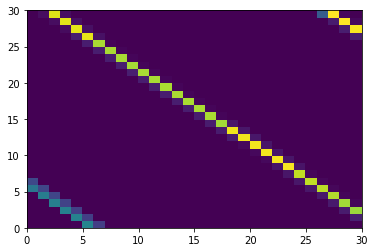

In [291]:
# testing of prob function
data_folder_path = "/Users/sandesh/dataproc/"
files = glob.glob(data_folder_path + "*.npy")

dat = np.load(files[1200])
x = np.random.randint(int(sub_size/2),100-int(sub_size/2))
y = np.random.randint(int(sub_size/2),100-int(sub_size/2))
prob = np.histogram(dat.item()['state_map']\
                    [(x - int(sub_size/2)) :(x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]\
                    .flatten(),[-1,0,1,2,3])[0]
prob = prob/np.sum(prob)
print(prob)
plt.pcolor(dat.item()['current_map']\
                    [(x - int(sub_size/2)) :(x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))])

[ 0.  0.  1.  0.]


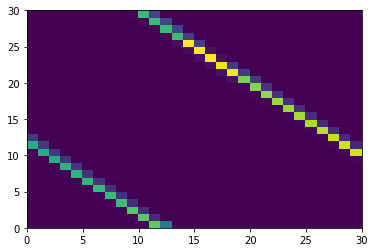

In [8]:
# Testing of the generated subimage data
data_folder_path = "/Users/ssk4/Downloads/data_subimage/"
files = glob.glob(data_folder_path + "*.npy")
i = np.random.randint(len(files))
load_dat = np.load(files[i])

plt.pcolor(load_dat.item()['current_map'])
print(load_dat.item()['label'])

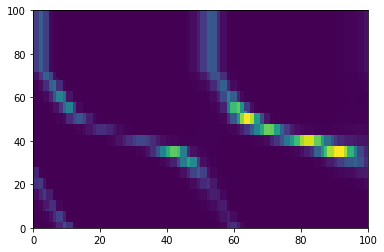

In [246]:
# Testing of the experimental data loading
import numpy as np
import scipy.interpolate

data_folder_path = "/Users/sandesh/exp_data/"
files = glob.glob(data_folder_path + "*.dat")

# Data format is V_LGD I_DC(nA) V_LGS I_AC(nA) t(sec)
# The format of the loaded array is [num_points,5]
dat = np.loadtxt(files[2])
sub_size = 100
grid_x = np.linspace(-1.4,-1.3,sub_size)
grid_y = np.linspace(-1.7,-1.6,sub_size)
xx,yy = np.meshgrid(grid_x,grid_y)
interpolated_data = scipy.interpolate.griddata((dat[:,0],dat[:,2]),dat[:,1],(xx, yy), method='nearest')

plt.pcolor(interpolated_data)
    

In [140]:
# CNN for learning!

# learn the states of a double dot
import numpy as np
import tensorflow as tf
import glob
import os
import time

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features,[-1,900]),tf.float32)
    
    # dense output layer
    out1 = tf.layers.dense(inputs=input_layer,units=2048)
    out2 = tf.layers.dense(inputs=out1,units=512)
    
    out = tf.layers.dense(inputs=out2,units=4)
    out_sm = tf.nn.softmax(out)

    loss = None
    train_op = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        onehot_labels = tf.one_hot(indices=tf.cast(labels,tf.int32),depth=4)
        loss = tf.losses.softmax_cross_entropy(onehot_labels,out_sm)

    # Configure the training op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=0.01,
            optimizer="SGD")

    # Generate predictions
    predictions= {
        "prob" : out,
        "states" : (tf.argmax(out,axis=1) - 1),
    }

    # Returna  ModelFnOps object
    return model_fn_lib.ModelFnOps(mode=mode,predictions=predictions,loss=loss, train_op=train_op)
    
def get_train_inputs():
    n_batch = 100
    index = np.random.choice(n_train,n_batch,replace=False)
    inp = []
    oup = []
    for i in index:
        dat = np.load(files[i])
        inp += [dat.item()['current_map'].flatten()]
        oup += [dat.item()['label']]

    inp = np.array(inp,dtype=np.float32)
    oup = np.array(oup,dtype=np.float32)
    
    x = tf.constant(inp)
    y = tf.argmax(tf.constant(oup),axis=1) - 1
    return x,y

def get_test_inputs():
    inp = []
    oup = []
       
    for file in files[n_train:(n_train+1000)]:
        dat = np.load(file)
        inp += [dat.item()['current_map'].flatten()]
        oup += [dat.item()['label']]
    
    inp = np.array(inp)
    oup = np.array(oup)
    
    x = tf.constant(inp,dtype=np.float32)
    y = tf.argmax(tf.constant(oup),axis=1) - 1
    return x,y

st = time.time()
# get the data
data_folder_path = "/Users/ssk4/Downloads/data_subimage/"
files = glob.glob(data_folder_path + "*.npy")

# shuffling the files to avoid any single dot bias
import random
random.shuffle(files)

n_samples = len(files)
train_sample_ratio = 0.8
n_train = int(train_sample_ratio * n_samples)

print("Total number of samples :",n_samples)
print("Training samples :",n_train)
print("Test samples :",n_samples - n_train)

st2 = time.time()
# create the estimator
dd_classifier = learn.Estimator(model_fn=cnn_model_fn)

# set up logging for predictions
tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

metrics = {
    "accuracy" : learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="states"),
}

dd_classifier.fit(
    input_fn=get_train_inputs,
    steps=5000,
    monitors=[logging_hook])

print("Training done in",time.time()-st2,"seconds.")

print("Total number of samples :",n_samples)
print("Training samples :",n_train)
print("Test samples :",n_samples - n_train)

# Training accuracy
#x,y = get_train_inputs()
#sess = tf.Session()
#y_argmax = tf.argmax(y,axis=1) - 1
#out = sess.run(y_argmax)

#pred = []
#predictions=dd_classifier.predict(input_fn=get_train_inputs)
#for i, p in enumerate(predictions):
#  pred += [p['states']]

#diff = abs(out - pred)
#arr = list(diff).count(0)/len(diff)
#print("Train Accuracy",arr)


# Test accuracy
#x,y = get_test_inputs()
#sess = tf.Session()
#y_argmax = tf.argmax(y,axis=1) - 1
#out = sess.run(y_argmax)

#pred = []
#predictions=dd_classifier.predict(input_fn=get_test_inputs)
#for i, p in enumerate(predictions):
#  pred += [p['states']]

#diff = abs(out - pred)
#arr = list(diff).count(0)/len(diff)
#print("Test Accuracy",arr)


Total number of samples : 76700
Training samples : 61360
Test samples : 15340
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12316d2e8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/hs/nm7qn85519v78y5bbl49h61h001sq3/T/tmpliide82u/model.ckpt.
INFO:tensorflow:loss = 1.38643, step = 1
INFO:tensorflow:
INFO:tensorflow:global_step/sec: 6.1885
INFO:tensorflow:loss = 1.2061, step = 101 (16.163 sec)
I

In [141]:
def get_test_inputs():
    inp = []
    oup = []
       
    for file in files[n_train:(n_train + 1000)]:
        dat = np.load(file)
        inp += [dat.item()['current_map'].flatten()]
        oup += [dat.item()['label']]
    
    inp = np.array(inp)
    oup = np.array(oup)
    
    x = tf.constant(inp,dtype=np.float32)
    y = tf.constant(oup,dtype=np.float32)
    return x,y

predictions=dd_classifier.predict(input_fn=get_test_inputs)

x,y = get_test_inputs()
sess = tf.Session()
y_argmax = tf.argmax(y,axis=1) - 1
out = sess.run(y_argmax)

pred = []
for i, p in enumerate(predictions):
  pred += [p['states']]

diff = abs(out - pred)
arr = list(diff).count(0)/len(diff)
print("Accuracy",arr)


INFO:tensorflow:Restoring parameters from /var/folders/hs/nm7qn85519v78y5bbl49h61h001sq3/T/tmpliide82u/model.ckpt-5000
Accuracy 0.013


In [143]:
pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [119]:
inp = []
oup = []

for file in files[n_train:(n_train+100)]:
    dat = np.load(file)
    inp += [dat.item()['current_map'].flatten()]
    oup += [dat.item()['label']]

inp = np.array(inp)
oup = np.array(oup)


[ 0.          0.          0.69333333  0.30666667]
1


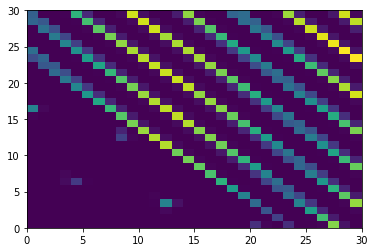

In [120]:
plt.pcolor(inp[45].reshape((30,30)))
print(oup[45])
print(pred[45])

In [122]:
lab = np.argmax(oup,axis=1) - 1
print(np.histogram(pred,[-1,0,1,2,3]))

(array([  0,   7, 993,   0]), array([-1,  0,  1,  2,  3]))


In [61]:
# Training accuracy
x,y = get_test_inputs()
sess = tf.Session()
y_argmax = tf.argmax(y,axis=1) - 1
out = sess.run(y_argmax)

pred = []
predictions=dd_classifier.predict(input_fn=get_train_inputs)
for i, p in enumerate(predictions):
  pred += [p['states']]

diff = abs(out - pred)
arr = list(diff).count(0)/len(diff)
print("Test Accuracy",arr)


INFO:tensorflow:Restoring parameters from /var/folders/hs/nm7qn85519v78y5bbl49h61h001sq3/T/tmpi1upgecr/model.ckpt-50000
Test Accuracy 0.7


In [133]:
predictions=dd_classifier.predict(input_fn=get_test_inputs)
pred = []
for i, p in enumerate(predictions):
  pred += [p['prob']]

INFO:tensorflow:Restoring parameters from /var/folders/hs/nm7qn85519v78y5bbl49h61h001sq3/T/tmpvfbc7v9h/model.ckpt-3780


In [138]:
print(pred[56])
sess = tf.Session()
print(sess.run(y[56]))

[ 0.00459172  0.33944264  0.65030032  0.01503329]
[ 0.00111111  0.28222221  0.71666664  0.        ]
